In [ ]:
import json
import numpy as np
import nltk
import time
import random
import string
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.regularizers import l2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

# Load dataset
with open('Combined_training.json') as file:
    data = json.load(file)
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess function
def preprocess(sentence):
    sentence = sentence.lower()
    sentence = ''.join([char for char in sentence if char not in string.punctuation])
    words = nltk.word_tokenize(sentence)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Extract patterns and tags
patterns = []
tags = []
all_responses = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        patterns.append(preprocess(pattern))
        tags.append(intent['tag'])
    all_responses.extend(intent['responses'])

# Encode the tags
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(tags)

# Tokenize and pad the patterns
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(patterns)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(patterns)
padded_sequences = pad_sequences(sequences, padding='post')

# TF-IDF vectorizer for responses
response_vectorizer = TfidfVectorizer().fit(all_responses)
response_vectors = response_vectorizer.transform(all_responses)

# Define the LSTM model creation function
def create_model(input_length, vocab_size, num_classes, embedding_dim=128, lstm_units=128, dense_units=64, dropout_rate=0.4, 
                 learning_rate=0.0005, lstm_dropout=0.3, recurrent_dropout=0.3, optimizer_choice='Adam', activation='relu', regularizer=None):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=activation, kernel_regularizer=regularizer))
    model.add(Dense(num_classes, activation='softmax'))
    
    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'Adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
training_times = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for train_index, val_index in kf.split(padded_sequences):
    print(f"Fold {fold}")
    X_train, X_val = padded_sequences[train_index], padded_sequences[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model(input_length=padded_sequences.shape[1], vocab_size=len(word_index)+1, num_classes=len(label_encoder.classes_),
                         embedding_dim=128, lstm_units=128, dense_units=64, dropout_rate=0.4, learning_rate=0.0005, 
                         lstm_dropout=0.3, recurrent_dropout=0.3, optimizer_choice='Adam', activation='relu', regularizer=l2(0.01))
    
    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=1)
    training_time = time.time() - start_time
    training_times.append(training_time)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    # Calculate metrics
    val_accuracy = accuracy_score(y_val, y_val_pred_classes)
    val_precision = precision_score(y_val, y_val_pred_classes, average='weighted')
    val_recall = recall_score(y_val, y_val_pred_classes, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred_classes, average='weighted')
    
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    # Print metrics for the current fold
    print(f'Training Time: {training_time:.2f} seconds')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Precision: {val_precision:.4f}')
    print(f'Recall: {val_recall:.4f}')
    print(f'F1 Score: {val_f1:.4f}')
    print("-" * 30)
    fold += 1

# Print average metrics
print("\nAverage Metrics Over All Folds:")
print(f'Average Training Time: {np.mean(training_times):.2f} seconds')
print(f'Average Validation Accuracy: {np.mean(val_accuracies):.4f}')
print(f'Average Precision: {np.mean(val_precisions):.4f}')
print(f'Average Recall: {np.mean(val_recalls):.4f}')
print(f'Average F1 Score: {np.mean(val_f1s):.4f}')

def get_response(user_input):
    user_input = preprocess(user_input)
    seq = tokenizer.texts_to_sequences([user_input])
    padded_seq = pad_sequences(seq, maxlen=padded_sequences.shape[1], padding='post')
    pred = model.predict(padded_seq)
    tag_index = np.argmax(pred)
    tag = label_encoder.inverse_transform([tag_index])[0]

    if max(pred[0]) < 0.6:  # Adjust threshold for confidence
        user_vector = response_vectorizer.transform([user_input])
        similarity_scores = cosine_similarity(user_vector, response_vectors)
        best_match_index = np.argmax(similarity_scores)
        best_match_response = all_responses[best_match_index]
        
        for intent in data['intents']:
            if best_match_response in intent['responses']:
                tag = intent['tag']
                break

    for intent in data['intents']:
        if intent['tag'] == tag:
            return random.choice(intent['responses'])

print("Chatbot is ready! Type 'quit' to exit.")

while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = get_response(user_input)
    print("Bot:", response)


In [1]:
import json
import numpy as np
import nltk
import time
import random
import string
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.regularizers import l2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load dataset
with open('Combined_training.json') as file:
    data = json.load(file)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess function
def preprocess(sentence):
    sentence = sentence.lower()
    sentence = ''.join([char for char in sentence if char not in string.punctuation])
    words = nltk.word_tokenize(sentence)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Extract patterns and tags
patterns = []
tags = []
all_responses = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        patterns.append(preprocess(pattern))
        tags.append(intent['tag'])
    all_responses.extend(intent['responses'])


In [3]:
# Encode the tags
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(tags)

# Tokenize and pad the patterns
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(patterns)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(patterns)
padded_sequences = pad_sequences(sequences, padding='post')

# TF-IDF vectorizer for responses
response_vectorizer = TfidfVectorizer().fit(all_responses)
response_vectors = response_vectorizer.transform(all_responses)


In [4]:
# Define the LSTM model creation function
def create_model(input_length, vocab_size, num_classes, embedding_dim=128, lstm_units=128, dense_units=64, dropout_rate=0.4, 
                 learning_rate=0.0005, lstm_dropout=0.3, recurrent_dropout=0.3, optimizer_choice='Adam', activation='relu', regularizer=None):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=activation, kernel_regularizer=regularizer))
    model.add(Dense(num_classes, activation='softmax'))
    
    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'Adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
training_times = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for train_index, val_index in kf.split(padded_sequences):
    print(f"Fold {fold}")
    X_train, X_val = padded_sequences[train_index], padded_sequences[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model(input_length=padded_sequences.shape[1], vocab_size=len(word_index)+1, num_classes=len(label_encoder.classes_),
                         embedding_dim=128, lstm_units=128, dense_units=64, dropout_rate=0.4, learning_rate=0.0005, 
                         lstm_dropout=0.3, recurrent_dropout=0.3, optimizer_choice='Adam', activation='tanh', regularizer=l2(0.01))
    
    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=1)
    training_time = time.time() - start_time
    training_times.append(training_time)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    # Calculate metrics
    val_accuracy = accuracy_score(y_val, y_val_pred_classes)
    val_precision = precision_score(y_val, y_val_pred_classes, average='weighted')
    val_recall = recall_score(y_val, y_val_pred_classes, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred_classes, average='weighted')
    
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    # Print metrics for the current fold
    print(f'Training Time: {training_time:.2f} seconds')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Precision: {val_precision:.4f}')
    print(f'Recall: {val_recall:.4f}')
    print(f'F1 Score: {val_f1:.4f}')
    print("-" * 30)
    fold += 1

# Print average metrics
print("\nAverage Metrics Over All Folds:")
print(f'Average Training Time: {np.mean(training_times):.2f} seconds')
print(f'Average Validation Accuracy: {np.mean(val_accuracies):.4f}')
print(f'Average Precision: {np.mean(val_precisions):.4f}')
print(f'Average Recall: {np.mean(val_recalls):.4f}')
print(f'Average F1 Score: {np.mean(val_f1s):.4f}')


Fold 1
Epoch 1/100
2/2 [==============================] - 1s 161ms/step - loss: 3.6189 - accuracy: 0.0595 - val_loss: 3.5975 - val_accuracy: 0.1905
Epoch 2/100
2/2 [==============================] - 0s 22ms/step - loss: 3.5972 - accuracy: 0.1310 - val_loss: 3.5745 - val_accuracy: 0.1905
Epoch 3/100
2/2 [==============================] - 0s 24ms/step - loss: 3.5752 - accuracy: 0.1310 - val_loss: 3.5504 - val_accuracy: 0.1905
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 3.5563 - accuracy: 0.1310 - val_loss: 3.5258 - val_accuracy: 0.1905
Epoch 5/100
2/2 [==============================] - 0s 35ms/step - loss: 3.5344 - accuracy: 0.1310 - val_loss: 3.5003 - val_accuracy: 0.1905
Epoch 6/100
2/2 [==============================] - 0s 35ms/step - loss: 3.5146 - accuracy: 0.1310 - val_loss: 3.4726 - val_accuracy: 0.1905
Epoch 7/100
2/2 [==============================] - 0s 35ms/step - loss: 3.4815 - accuracy: 0.1310 - val_loss: 3.4414 - val_accuracy: 0.1905
Epoch 8/100


Epoch 1/100
2/2 [==============================] - 1s 149ms/step - loss: 3.6287 - accuracy: 0.0595 - val_loss: 3.6154 - val_accuracy: 0.1429
Epoch 2/100
2/2 [==============================] - 0s 21ms/step - loss: 3.6050 - accuracy: 0.1786 - val_loss: 3.5967 - val_accuracy: 0.1429
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 3.5829 - accuracy: 0.1548 - val_loss: 3.5783 - val_accuracy: 0.1429
Epoch 4/100
2/2 [==============================] - 0s 35ms/step - loss: 3.5616 - accuracy: 0.1429 - val_loss: 3.5588 - val_accuracy: 0.1429
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: 3.5268 - accuracy: 0.1429 - val_loss: 3.5365 - val_accuracy: 0.1429
Epoch 6/100
2/2 [==============================] - 0s 36ms/step - loss: 3.5047 - accuracy: 0.1429 - val_loss: 3.5116 - val_accuracy: 0.1429
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 3.4745 - accuracy: 0.1429 - val_loss: 3.4857 - val_accuracy: 0.1429
Epoch 8/100
2/2 [==

Epoch 1/100
2/2 [==============================] - 1s 162ms/step - loss: 3.6400 - accuracy: 0.0238 - val_loss: 3.6185 - val_accuracy: 0.2381
Epoch 2/100
2/2 [==============================] - 0s 23ms/step - loss: 3.6166 - accuracy: 0.1310 - val_loss: 3.5965 - val_accuracy: 0.2381
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 3.5955 - accuracy: 0.1310 - val_loss: 3.5761 - val_accuracy: 0.2381
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 3.5724 - accuracy: 0.1310 - val_loss: 3.5526 - val_accuracy: 0.2381
Epoch 5/100
2/2 [==============================] - 0s 35ms/step - loss: 3.5610 - accuracy: 0.1190 - val_loss: 3.5269 - val_accuracy: 0.2381
Epoch 6/100
2/2 [==============================] - 0s 35ms/step - loss: 3.5304 - accuracy: 0.1190 - val_loss: 3.5006 - val_accuracy: 0.2381
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 3.5157 - accuracy: 0.1190 - val_loss: 3.4715 - val_accuracy: 0.2381
Epoch 8/100
2/2 [==

Epoch 1/100
2/2 [==============================] - 1s 149ms/step - loss: 3.6213 - accuracy: 0.1190 - val_loss: 3.6177 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 22ms/step - loss: 3.5982 - accuracy: 0.1786 - val_loss: 3.6065 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 3.5626 - accuracy: 0.1786 - val_loss: 3.5968 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 3.5319 - accuracy: 0.1786 - val_loss: 3.5891 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 35ms/step - loss: 3.4947 - accuracy: 0.1786 - val_loss: 3.5845 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 35ms/step - loss: 3.4601 - accuracy: 0.1786 - val_loss: 3.5843 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 36ms/step - loss: 3.4081 - accuracy: 0.1786 - val_loss: 3.5920 - val_accuracy: 0.

Epoch 1/100
2/2 [==============================] - 1s 150ms/step - loss: 3.6239 - accuracy: 0.0595 - val_loss: 3.6096 - val_accuracy: 0.1429
Epoch 2/100
2/2 [==============================] - 0s 22ms/step - loss: 3.5990 - accuracy: 0.1190 - val_loss: 3.5941 - val_accuracy: 0.1429
Epoch 3/100
2/2 [==============================] - 0s 27ms/step - loss: 3.5790 - accuracy: 0.1429 - val_loss: 3.5780 - val_accuracy: 0.1429
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 3.5575 - accuracy: 0.1548 - val_loss: 3.5613 - val_accuracy: 0.1429
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: 3.5314 - accuracy: 0.1071 - val_loss: 3.5429 - val_accuracy: 0.1429
Epoch 6/100
2/2 [==============================] - 0s 38ms/step - loss: 3.5090 - accuracy: 0.1310 - val_loss: 3.5219 - val_accuracy: 0.1429
Epoch 7/100
2/2 [==============================] - 0s 38ms/step - loss: 3.4744 - accuracy: 0.1429 - val_loss: 3.4973 - val_accuracy: 0.1429
Epoch 8/100
2/2 [==

1/1 [==============================] - 0s 110ms/step
Training Time: 9.92 seconds
Validation Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
------------------------------

Average Metrics Over All Folds:
Average Training Time: 9.95 seconds
Average Validation Accuracy: 0.9048
Average Precision: 0.8976
Average Recall: 0.9048
Average F1 Score: 0.8990


In [7]:
def get_response(user_input):
    user_input = preprocess(user_input)
    seq = tokenizer.texts_to_sequences([user_input])
    padded_seq = pad_sequences(seq, maxlen=padded_sequences.shape[1], padding='post')
    pred = model.predict(padded_seq)
    tag_index = np.argmax(pred)
    tag = label_encoder.inverse_transform([tag_index])[0]

    if max(pred[0]) < 0.6:  # Adjust threshold for confidence
        user_vector = response_vectorizer.transform([user_input])
        similarity_scores = cosine_similarity(user_vector, response_vectors)
        best_match_index = np.argmax(similarity_scores)
        best_match_response = all_responses[best_match_index]
        
        for intent in data['intents']:
            if best_match_response in intent['responses']:
                tag = intent['tag']
                break

    for intent in data['intents']:
        if intent['tag'] == tag:
            return random.choice(intent['responses'])

print("Chatbot is ready! Type 'quit' to exit.")

while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = get_response(user_input)
    print("Bot:", response)


Chatbot is ready! Type 'quit' to exit.


You:  hi


1/1 [==============================] - 0s 12ms/step
Bot: Hey! How can I help?


You:  how are you


1/1 [==============================] - 0s 11ms/step
Bot: An academic appeal is a request from a student to the Dean of their School to review a decision made by the Board of Examiners about an assessment decision. If you want tomake an appeal [https://ask.herts.ac.uk/academic-appeals-requests-for-the-review-of-assessment-decisions], you must request a review of your results within 10 working days of their publication. You can also contact your programme leader or cohort leader, or Herts SU’s Advice and Support centre for guidance.


You:  when can i appeal


1/1 [==============================] - 0s 11ms/step
Bot: An academic appeal is a request from a student to the Dean of their School to review a decision made by the Board of Examiners about an assessment decision. If you want tomake an appeal [https://ask.herts.ac.uk/academic-appeals-requests-for-the-review-of-assessment-decisions], you must request a review of your results within 10 working days of their publication. You can also contact your programme leader or cohort leader, or Herts SU’s Advice and Support centre for guidance.


You:  when can i appal


1/1 [==============================] - 0s 11ms/step
Bot: Herts SU’s Advice and Support team [https://hertssu.com/your-support/]provides free, confidential, and impartial advice and support on a range of student issues, including those of an academic nature, such as information on academic appeals and academic misconduct through to study skills support. If you want to get in touch with the team for advice regarding your academic experience, you canbook an appointment. [https://hertssu.com/your-support/] Herts SU also runsStudy Smart [https://hertssu.com/your-support/academic-advice/study-smart/], a scheme which is designed to accommodate your unique learning preferences to make you feel more confident with your assignments, revision techniques and exams. Sessions are one-to-one tutorials where you'll be exploring new study strategies that are designed to lead to efficient and interesting ways that you can use to approach your assignments and deadlines.


You:  what is student wllbeing support


1/1 [==============================] - 0s 16ms/step
Bot: Good day! What do you need help with?


You:  what is future of ai 


1/1 [==============================] - 0s 10ms/step
Bot: Hello! How can I assist you today?


You:  what is future of ai tools


1/1 [==============================] - 0s 10ms/step
Bot: The only occasions where you may use AI tools in your assessment is if you have explicit permission from your tutor in your assessment brief. Your assessment brief will include information on how to declare any use of such tools, and you can speak to your tutor for guidance. If you do not reference your use, then this will constitute academic misconduct. Our current University policy on academic misconduct adequately covers the misuse of such tools, but we are updating them to be clearer on the matter. Unauthorised use of artificially generated material (AI) in researching or presenting material for an assessment is an academic misconduct offence if you use AI tools in producing your assessment unless the use of AI tools is expressly permitted. However, even if expressly permitted, where you do not declare that you have used an artificial intelligence tool(s) in the production of your assessment, or you are dishonest about the ex

You:  quit


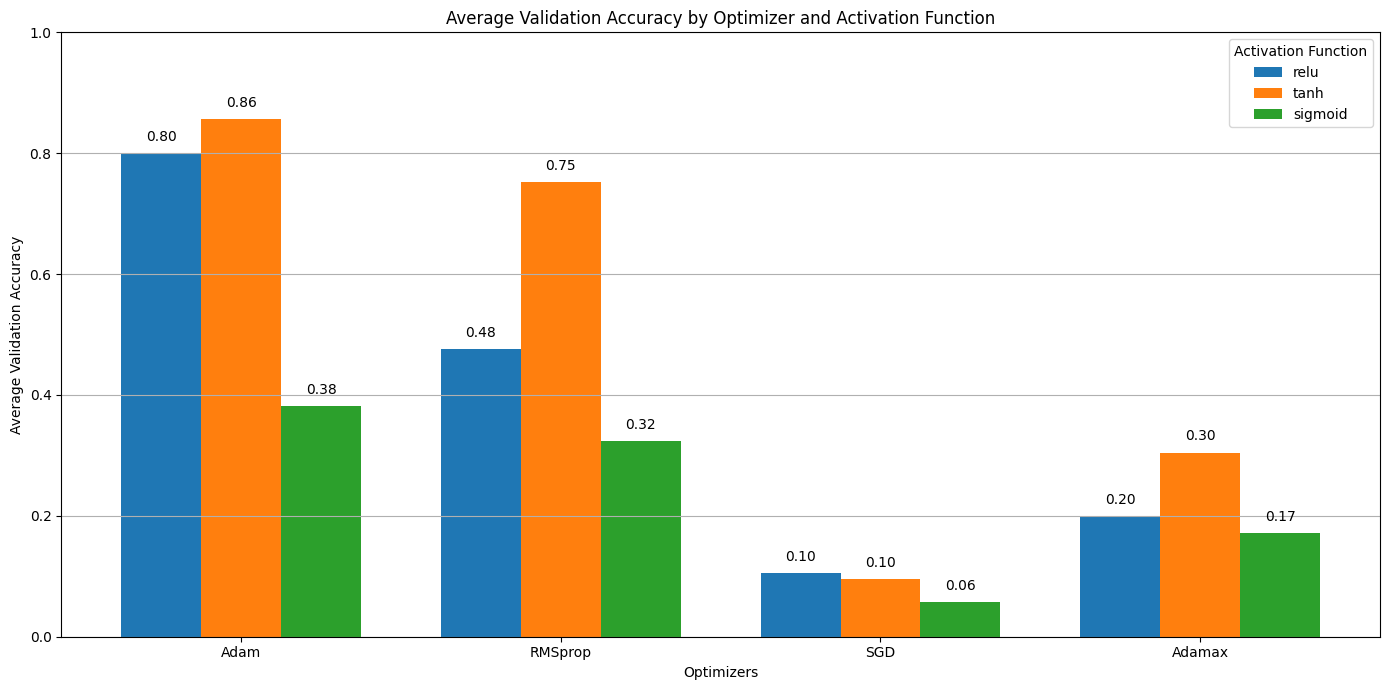

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
optimizers = ['Adam', 'RMSprop', 'SGD', 'Adamax']
activations = ['relu', 'tanh', 'sigmoid']
accuracies = {
    'relu': [0.8000, 0.4762, 0.1048, 0.2000],
    'tanh': [0.8571, 0.7524, 0.0952, 0.3048],
    'sigmoid': [0.3810, 0.3238, 0.0571, 0.1714]
}

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))

# Set width of bars
bar_width = 0.25
index = np.arange(len(optimizers))

# Plot each activation function's data
for i, (activation, accs) in enumerate(accuracies.items()):
    plt.bar(index + i * bar_width, accs, bar_width, label=f'{activation}')

# Customization
plt.xlabel('Optimizers')
plt.ylabel('Average Validation Accuracy')
plt.title('Average Validation Accuracy by Optimizer and Activation Function')
plt.xticks(index + bar_width, optimizers)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.legend(title='Activation Function')
plt.grid(axis='y')

# Adding the accuracy values on top of the bars
for i, (activation, accs) in enumerate(accuracies.items()):
    for j, acc in enumerate(accs):
        plt.text(j + i * bar_width, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=10)

plt.tight_layout()

# Save the figure
plt.savefig('LSTM.png', format='png')  # Save as PNG file

plt.show()
